# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Standardizing, Splitting, and Downsampling](#2.0-Standardizing,-Splitting,-and-Downsampling)

3. [Modeling](#3.0-Modeling)


# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to classify BC addresses as ransomware or not. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method. 

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

#### 1.2.0 Information:
---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income = boxcox of income
    
- bc_length = boxcox of length
    
- yeo_weight = yeo of weight
   
- logbc_n_address = boxcox log of address

- bc_neighbors = box of neighbors
   
- sig_looped = sigmoid of looped
    
- log_count = log of count
   
- day_of_week = {'Monday':0,...,'Sunday': 6}
    

### 1.3 Packages and helper functions

In [374]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

from scipy import stats

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
# Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

#from prettytable import PrettyTable
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
DROP = False
READ_STATE = True

### 1.4 Importing saved data

In [3]:
NF = 5 

In [4]:
fname = 'X_train_y_train_X_test_y_test_0'+str(NF)+'.pickle'

In [5]:
Xy   = pd.read_pickle('data/' + fname)
Xy_d = pd.read_pickle('data/'+ 'derived'+fname)
Xy_e = pd.read_pickle('data/'+'encoded'+fname)

In [6]:
for i in [0,1,2,3]:
    Xy[i].reset_index(drop=True,inplace=True)
    Xy_d[i].reset_index(drop=True,inplace=True)
    #Xy_e[i].reset_index(drop=True,inplace=True)


In [7]:
# Test/train split of unmodified data 
X_train = Xy[0]
y_train = Xy[1]
X_test  = Xy[2]
y_test  = Xy[3]

In [8]:
X_train.drop(labels=['address'],axis=1,inplace=True)
X_test.drop(labels=['address'],axis=1,inplace=True)
X_train_ns = X_train.to_numpy() # not std. transformed
X_test_ns  = X_test.to_numpy()  # not std. transformed

In [9]:
# Test/train split of transformed data (skew reduced)
X_train_d = Xy_d[0]
y_train_d = Xy_d[1]
X_test_d  = Xy_d[2]
y_test_d  = Xy_d[3]

In [10]:
X_train_d.drop(labels=['address'],axis=1,inplace=True)
X_test_d.drop(labels=['address'],axis=1,inplace=True)

In [11]:
# Test/train split of transformed, std. normalized, and encoded data
# dtype=numpy arrays.  
# X_e has address is already dropped!
X_train_e = Xy_e[0] 
y_train_e = Xy_e[1] # labels
X_test_e  = Xy_e[2]
y_test_e  = Xy_e[3] # labels

In [12]:
X_train_e.shape

(2245856, 22)

In [13]:
colnames = ['year',
 'day',
 'length',
 'weight',
 'count',
 'looped',
 'neighbors',
 'income',
 'bc_income',
 'bc_length',
 'yeo_weight',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count',
  'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

# make data frame
X_train_e_df = pd.DataFrame(X_train_e, columns=colnames)
X_test_e_df = pd.DataFrame(X_test_e, columns=colnames)
print('X_train_e has been standardized to zero mean and unit variance')
X_train_e_df['looped'].mean(), X_train_e_df['looped'].var()
           

X_train_e has been standardized to zero mean and unit variance


(-2.2295261401004454e-17, 1.00000044526472)

In [14]:
y_train.reset_index(drop=True,inplace=True)

In [15]:
y_test.value_counts()

labels
0.0       661316
1.0         9525
dtype: int64

In [16]:
y_test_e.value_counts()

labels
0.0       661316
1.0         9525
dtype: int64

In [17]:
y_test_e.reset_index(drop=True,inplace=True)

In [18]:
y_test_e == y_test

,labels
0,True
1,True
2,True
3,True
4,True
...,...
670836,True
670837,True
670838,True
670839,True


# 2.0 Standardizing,  Splitting, and Downsampling

In [19]:
print('Training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_train['labels']),
    len(y_train['labels']) - sum(y_train['labels'])
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_train['labels'])/(len(y_train['labels'])) * 100)))

Training set has 2245856 rows and 8 columns.
Testing set has 670841 rows and 8 columns.
Training set has 31888.0 points that belong to postitive class (ransomware) and 2213968.0 points that belong to negative class (white).
Percentage of positive class data-points: 1.42%


## 2.1 Sampling

### 2.1.0 Downsampling 

In [20]:
class Sampler:
    
    def __init__(self,X):
        self.X_df = pd.DataFrame(X)
        self.positive_df = pd.DataFrame([], columns = self.X_df.columns)
        self.negative_df = pd.DataFrame([], columns = self.X_df.columns)
        self.combined_df = pd.DataFrame([], columns = self.X_df.columns) 
        self.X_train_sm =  pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_sm =  pd.DataFrame([], columns = ['lables'])
        self.X_train_rus = pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_rus =  pd.DataFrame([], columns = ['lables'])

        
    
    def up_samp_smote(self, X_train, y_train, ratio):
        """Upsamples minority class using SMOTE.
        Ratio argument is the percentage of the upsampled minority class in relation
        to the majority class. 
        """
        sm = SMOTE(random_state=RAND_STATE, sampling_strategy=ratio)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
        #print(len(X_train_sm), len(y_train_sm))
        self.X_train_sm, self.y_train_sm = X_train_sm, y_train_sm
       
    
    def down_samp_rand(self, X_train, y_train, ratio):
        """Downsamples majority class using random sampling.
        Ratio argument is the ratio of minority class to the downsampled majority 
        """
        rus = RandomUnderSampler(sampling_strategy=ratio,random_state=RAND_STATE) 
        X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
        self.X_train_rus, self.y_train_rus = X_train_rus, y_train_rus
    
    
    def down_samp(self, y_train, prob=0.015):
        index = 0

        for index_df, row in tqdm(self.X_df.iterrows(), total=self.X_df.shape[0]):
            if y_train[index] == 0:
                if np.random.uniform(0, 1) < prob:
                    #picking negative class with a probability=prob
                    self.negative_df = self.negative_df.append(row, ignore_index=True)
                    index += 1
                else:
                    index += 1
            elif y_train[index] == 1:
            #picking all positive data-points
                self.positive_df = self.positive_df.append(row, ignore_index=True)
                index += 1
        self.combined_df = self.positive_df.append(self.negative_df, ignore_index = True)

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [21]:
e_ds = Sampler(X_train_e_df) # sampler constructor 

In [22]:
e_ds.down_samp_rand(X_train_e, y_train_e['labels'], 0.05) # downsample using random resampling

In [23]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.25) # upsampling using SMOTE

In [24]:
y_train.value_counts()

labels
0.0       2213968
1.0         31888
dtype: int64

In [25]:
e_ds.y_train_sm.value_counts()

0.0    637760
1.0    159440
Name: labels, dtype: int64

In [26]:
e_ds.y_train_sm.value_counts(normalize=True)

0.0    0.8
1.0    0.2
Name: labels, dtype: float64

In [27]:
e_ds.down_samp(y_train['labels']) # down sampling for combined (useful for plotting)

  0%|          | 0/2245856 [00:00<?, ?it/s]

In [28]:
# make new data frames for positive and negative down sampled encoded data
combined_X_e_df = e_ds.combined_df
combined_X_e = combined_X_e_df.to_numpy()
combined_labels = np.append([1] * e_ds.positive_df.shape[0], 
                            [0] * e_ds.negative_df.shape[0])

**d_ds** <n>
- standard scaled and normalized for distance modeling.
- Split of X_train_ss [standardized, encoded] without column headers.

In [29]:
#d_ds = Sampler(X_train_d) # sampler constructor 
#d_ds.up_samp_smote(y_train['labels'], .75) # upsampling using SMOTE
#d_ds.down_samp(d_ds.y_train_sm) # down sampling


#combined_X_d_df = d_ds.combined_df
#combined_X_d = combined_X_d_df.to_numpy()

#combined_y_d = np.append(
#    [1] * d_ds.positive_df.shape[0], 
#    [0] * d_ds.negative_df.shape[0]
#)

**class n_ds** <n>
- for plotting and tree modeling.
- Split of X_train [non-standardized, non-encoded].

In [30]:
#n_ds = Sampler(X_train_ns) # sampler constructor 
#n_ds.up_samp_smote(y_train['labels'], .75) # upsampling using SMOTE
#n_ds.down_samp(n_ds.y_train_sm) # down sampling

#combined_X_ns_df = n_ds.combined_df
#combined_X_ns = combined_X_ns_df.to_numpy()
#combined_y_ns = np.append([1] * n_ds.positive_df.shape[0], 
#                            [0] * n_ds.negative_df.shape[0])

## 2.2 Visualization and EDA

### 2.2.0 Univariate

In [31]:
def pdf_plot_compare(ft_name):
    sns.distplot(e_ds.negative_df[ft_name], label = 'White')
    sns.distplot(e_ds.positive_df[ft_name], label = 'Ransomware')
    plt.legend()
    plt.title('distribution of ' + ft_name )
    plt.show()

In [32]:
cols_new = X_train_e_df.columns
cols_new=cols_new[:-7]

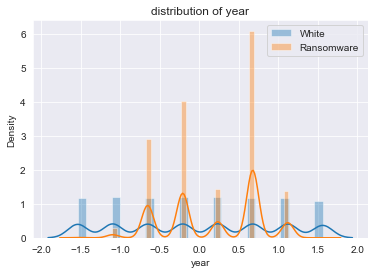

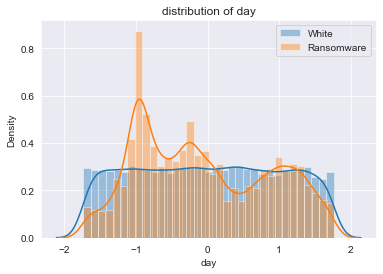

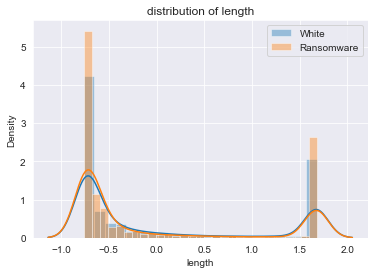

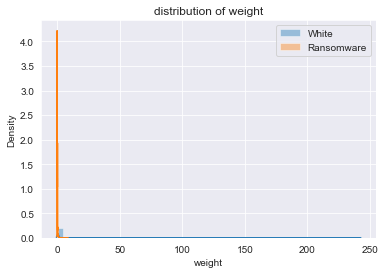

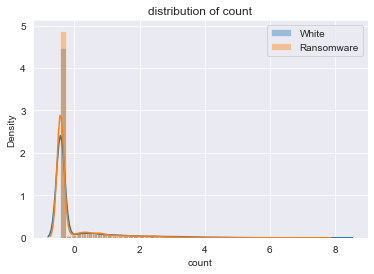

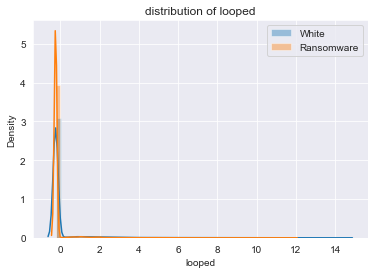

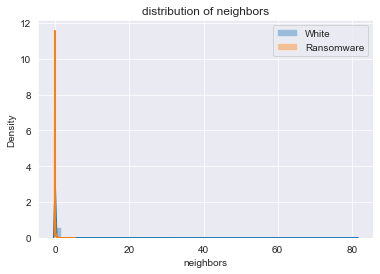

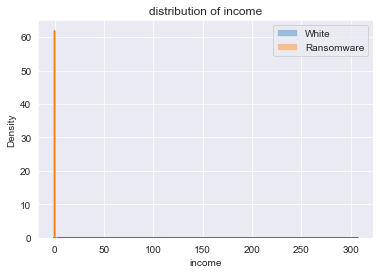

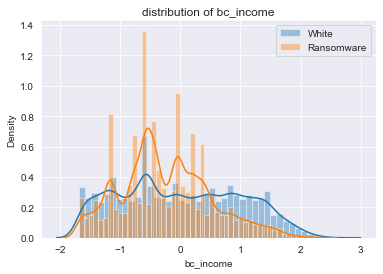

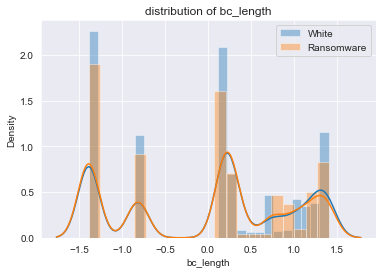

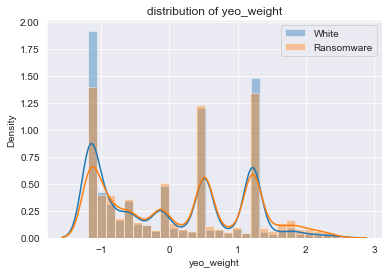

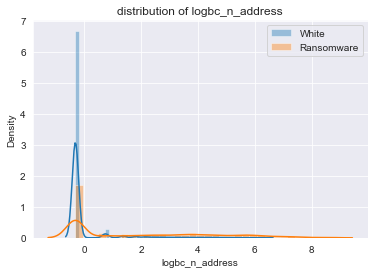

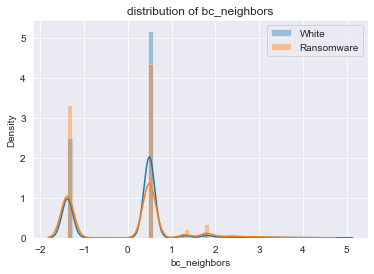

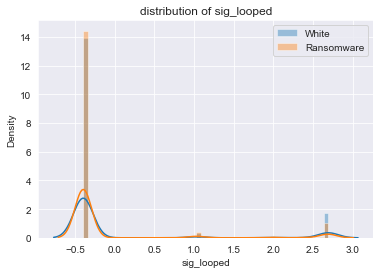

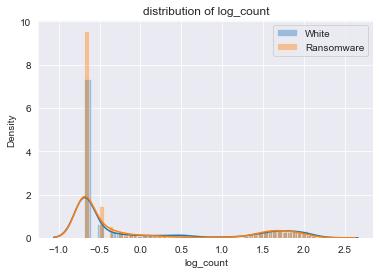

In [33]:
for fts in cols_new:
        pdf_plot_compare(fts)

### 2.2.1 Multivariate

Correlation matrix

In [34]:
n_corr = X_train_e_df.corr()
corr_abs  = n_corr.abs()
upper_triangle =corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > 0.89)]

['log_count']

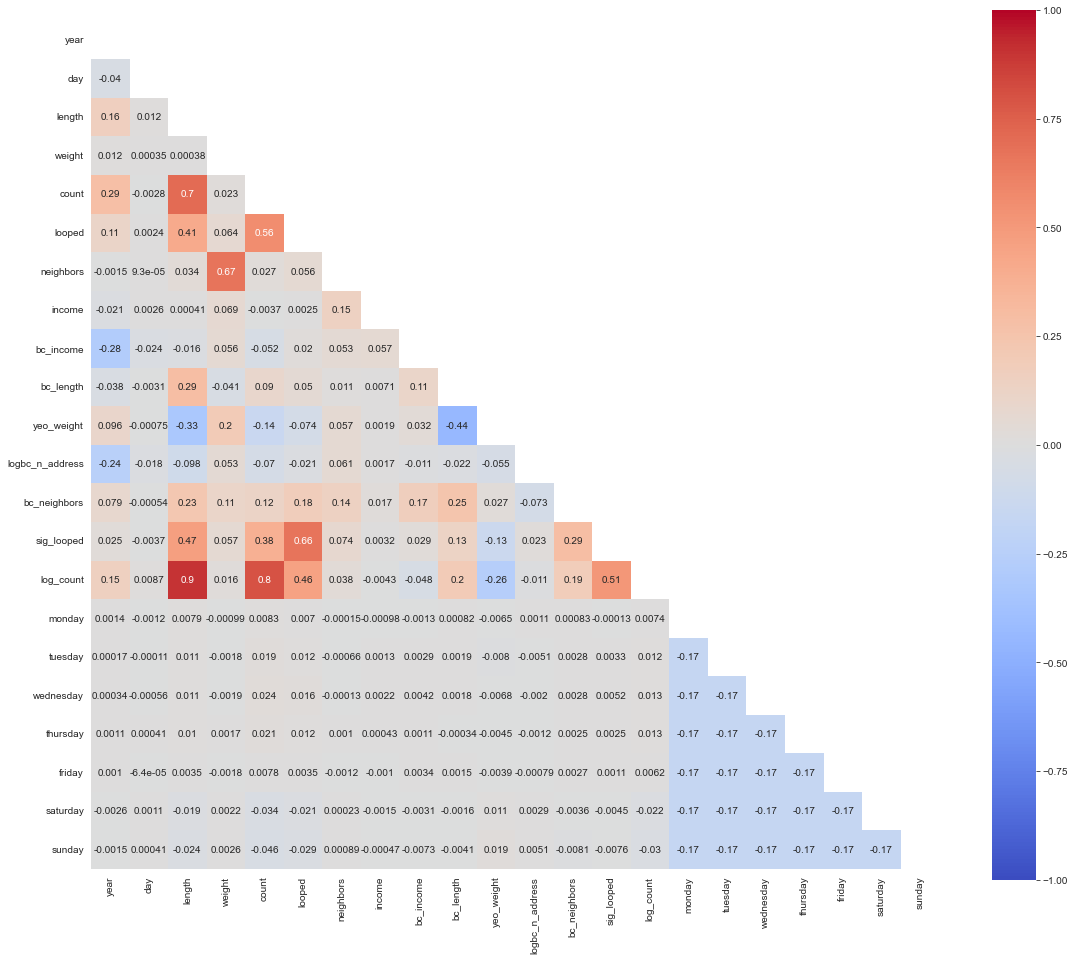

In [35]:
mask = np.zeros_like(n_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(19, 16))
    ax = sns.heatmap(n_corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

Remove highly correlated column

In [36]:
# drop highly correlated column
#
def drop_col(df,cols):
    return df.drop(columns=[cols],inplace=True)

if DROP == True:
    colnames = list(np.delete(colnames,colnames.index('log_count')))

    #drop_log_cnt = lambda x: x.drop(columns=['log_count'],inplace=True)

    combined_X_e_df.drop(columns=['log_count'],inplace=True)
    X_train_e_df.drop(columns=['log_count'],inplace=True)
    X_test_e_df.drop(columns=['log_count'],inplace=True)
#
# convert to numpy again
#
    X_train_e = X_train_e_df.to_numpy()
    X_test_e = X_test_e_df.to_numpy()
    combined_X_e = combined_X_e_df.to_numpy()

# 3.0 Modeling

In [299]:
def plot_roc(model,X,y,plot_title):
    plot_roc_curve(model,X,y)
    plt.title(plot_title)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
    plt.legend()
    plt.show()

def confusion_mat(y,y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Reds')

def tabulate_scores_df(model_name, y_test, y_pred):
 
    df2 = pd.DataFrame([[
        model_name,
        accuracy_score(y_true = y_test, y_pred = y_pred),
        precision_score(y_true = y_test, y_pred = y_pred),
        recall_score(y_true = y_test, y_pred = y_pred),
        f1_score(y_true = y_test, y_pred = y_pred)]],
        columns = ['Type','Accuracy','Precision','Recall','F1-Score'])

    return df2
    

Test/train split of (down) sampled 50/50 data 

In [300]:
# Generate a mini (balanced) data-set for hyper-parameter tuning
combined_X_train, combined_X_test, combined_y_train, combined_y_test = train_test_split(
    combined_X_e_df,   # standardard X with  1 = pos/neg class ratio
    combined_labels, # y 
    test_size = SPLIT_RATIO,  
    shuffle = True,
    random_state = RAND_STATE
)

In [301]:
score_names = ['Model Name','Accuracy','Precision','Recall','F1-Score']
scores_df = pd.DataFrame([], columns = score_names)

In [379]:
class Model:
    def __init__(self, x_tr, y_tr, X_tr, X_tst, routine, params, classifier, crss_vldtr=None):
        '''Model'''
        self.classifier = classifier
        self.X_tst = X_tst


        #  randomized search on hyper parameters
        search = RandomizedSearchCV(
            estimator = routine,
            param_distributions = params,
            scoring = 'recall',
            cv = crss_vldtr,
            n_jobs = -1,
            verbose = 1,
            random_state = RAND_STATE,
            return_train_score = True,
            n_iter = 5
        )
        if READ_STATE == True:
            tag = input('Enter head of parameter file to read')
            rf_hps_fname = tag + '_bestparams_sm_e_05.csv'
            print('reading file ', rf_hps_fname)
            bps = pd.read_csv(rf_hps_fname, index_col=False).to_dict('list')
            bps.pop('Unnamed: 0')
            ks = [k for k in bps.keys()]
            vs = [v[0] for v in bps.values()]
            self.best_params = dict( zip(ks,vs) )
        else:
            search.fit(x_tr, y_tr)
            self.best_params = search.best_params_

        print(self.best_params)
        tuned = classifier(**self.best_params,# n_jobs = -1,
                            random_state = RAND_STATE)
        self.tuned = tuned
        # fit
        tuned.fit(x_tr, y_tr)
        # predict
        self.preds_train = tuned.predict(X_tr)
        self.preds_test  = tuned.predict(X_tst)
        self.params      = tuned.get_params()

    def score(self,y_tr,y_tst):
        trn_score_df = tabulate_scores_df('trn', y_tr, self.preds_train)
        tst_score_df = tabulate_scores_df('tst', y_tst, self.preds_test)
        score_df = trn_score_df.append(tst_score_df)
        return score_df

    def roc(self, y_tst, title):
        plot_roc(self.tuned, self.X_tst,y_tst, title)

    def conf_mat(self, y_tr, y_tst):
        plt.figure(figsize=(15,7))

        plt.subplot(1,2,1) # first heatmap
        confusion_mat(y_tr, self.preds_train)

        plt.subplot(1,2,2) # first heatmap
        confusion_mat(y_test, self.preds_test)

        plt.show()

    def feature_imps(self):
        feat_ranks_df = pd.DataFrame(np.ravel(self.tuned.feature_importances_), index=colnames)
        feat_ranks_df.columns = ['feature importance']
        feat_ranks_df.sort_values(by='feature importance', ascending=False)
        return feat_ranks_df

In [ ]:
counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

In [ ]:
from sklearn.svm import LinearSVC

In [365]:
models = {
    "sgd": { "estimater": SGDClassifier(),
             "params": {
                 "loss" : [ "log_loss", "perceptron"],
                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
                 "penalty" : ["l2", "l1", "elasticnet"],
                 "class_weight" : ['balanced', None],}
             },
    "rf": { "estimater": RandomForestClassifier(),
            "params": {
                'max_depth' : [2,5,10,15],
                'n_estimators' : [100, 500, 1000],
                "class_weight" : ['balanced', None],}
            },
    "xgb": {"estimater": XGBClassifier(),
            "params": {
                'n_estimators': stats.randint(150, 1000),
                'learning_rate': stats.uniform(0.01, 0.59),
                'subsample': stats.uniform(0.3, 0.6),
                'max_depth': [3, 4, 5, 6, 7],
                'colsample_bytree': stats.uniform(0.5, 0.4),
                'scale_pos_weight' : stats.uniform(estimate,estimate**2),
                'min_child_weight': [1, 2, 3, 4],}
            },
    "lsvc": { "estimater": LinearSVC(),
              "params": { }
              },
    "svc": { "estimater": SVC(),
             "params": {
                 'C': [0.1,1, 10, 100, 1000],
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'kernel': ['rbf'],}
             }
}

## 3.1 Stochastic Gradient Descent (SGD)

* Models based on the relative spatial distribution of data in the observation space. For these models, the training data must be transformed to zero mean unit variance.

### 3.1.0 SGD Classification

#### 3.1.0.1 Optimization

In [367]:
models['rf']

{'estimater': RandomForestClassifier(),
 'params': {'max_depth': [2, 5, 10, 15],
  'n_estimators': [100, 500, 1000],
  'class_weight': ['balanced', None]}}

In [305]:
# Create model
sgd_cl = SGDClassifier(random_state = RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd_params_in = {
    "loss" : [ "log_loss", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet"],
    "class_weight" : ['balanced', None]
}
sgd = Model(
    e_ds.X_train_sm, e_ds.y_train_sm,
    X_train_e, X_test_e,
    sgd_cl, sgd_params_in, SGDClassifier)

reading file  sgd_bestparams_sm_e_05.csv
{'penalty': 'l2', 'loss': 'perceptron', 'class_weight': 'balanced', 'alpha': 0.01}


In [306]:
sgd.params

{'alpha': 0.01,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'perceptron',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [307]:
sgd.score(y_train_e,y_test_e)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.676956,0.025152,0.576079,0.048199
0,tst,0.683702,0.025466,0.570919,0.048758


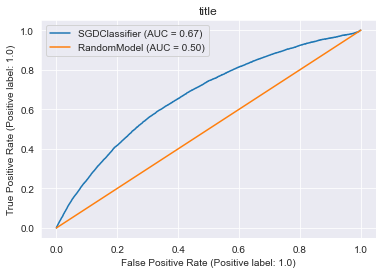

In [308]:
sgd.roc(y_test_e,'title')

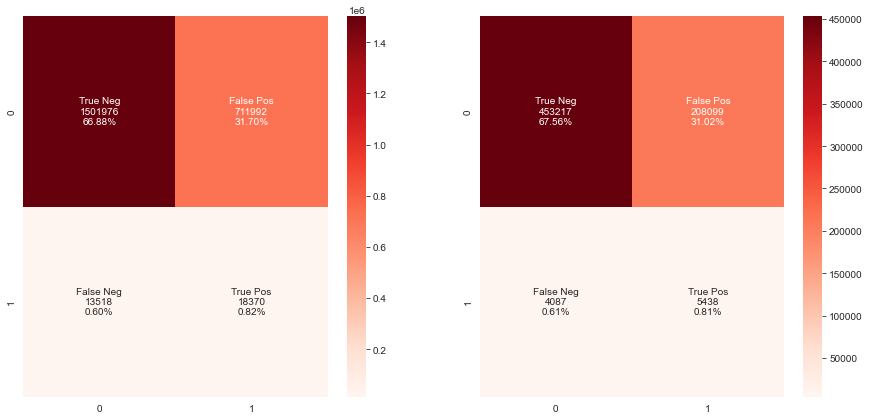

In [309]:
sgd.conf_mat(y_train_e, y_test)

In [310]:
sgd_bps = sgd.best_params

In [311]:
if READ_STATE == False:
    pd.DataFrame([sgd_bps]).to_csv('sgd_bestparams_sm_e_05.csv')

In [226]:
scores_df = scores_df.append(sgd.score(y_train_e,y_test_e))
scores_df.reset_index(drop=True,inplace=True)

In [312]:
print(classification_report(y_test_e, sgd.preds_test))
print(classification_report(y_train_e, sgd.preds_train))

              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81    661316
         1.0       0.03      0.57      0.05      9525

    accuracy                           0.68    670841
   macro avg       0.51      0.63      0.43    670841
weighted avg       0.98      0.68      0.80    670841

              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81   2213968
         1.0       0.03      0.58      0.05     31888

    accuracy                           0.68   2245856
   macro avg       0.51      0.63      0.43   2245856
weighted avg       0.98      0.68      0.79   2245856



## 3.2 Decision Trees

### 3.2.0 Random Forest Classification

#### 3.2.0.1 Opimization


In [313]:
# parameter search
rf_params_in = {
    'max_depth' : [2,5,10,15],
    'n_estimators' : [100, 500, 1000],
    "class_weight" : ['balanced', None]
}

rf_cl = RandomForestClassifier(n_jobs = -1,random_state = RAND_STATE)

rfc = Model(
        e_ds.X_train_sm, e_ds.y_train_sm,
        X_train_e, X_test_e,
        rf_cl, rf_params_in, RandomForestClassifier)

rf_bps = rfc.best_params

reading file  rf_bestparams_sm_e_05.csv
{'n_estimators': 1000, 'max_depth': 15, 'class_weight': 'balanced'}


In [325]:
rfc.params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

####  3.2.0.1 RF model results

In [323]:
rf_scores = rfc.score(y_train_e,y_test_e)
rf_scores

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.940706,0.186698,0.946312,0.311868
0,tst,0.902312,0.118172,0.909921,0.209179


In [324]:
print(classification_report(y_train, rfc.preds_train))
print(classification_report(y_test, rfc.preds_test))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97   2213968
         1.0       0.19      0.95      0.31     31888

    accuracy                           0.94   2245856
   macro avg       0.59      0.94      0.64   2245856
weighted avg       0.99      0.94      0.96   2245856

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    661316
         1.0       0.12      0.91      0.21      9525

    accuracy                           0.90    670841
   macro avg       0.56      0.91      0.58    670841
weighted avg       0.99      0.90      0.94    670841



In [317]:
rf_opt_down_feat_ranks_df = pd.DataFrame(np.ravel(rfc.tuned.feature_importances_), index=colnames)
rf_opt_down_feat_ranks_df.columns = ['feature importance']
rf_opt_down_feat_ranks_df.sort_values(by='feature importance', ascending=False)

,feature importance
year,0.313469
logbc_n_address,0.288787
bc_income,0.090060
income,0.067281
day,0.051200
neighbors,0.023121
weight,0.022887
bc_neighbors,0.022514
yeo_weight,0.022354
log_count,0.017336


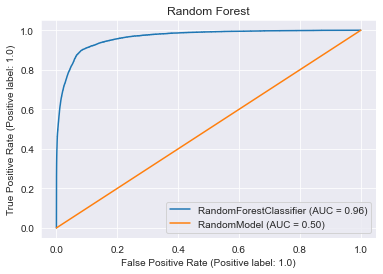

In [318]:
rfc.roc(y_test,'Random Forest')

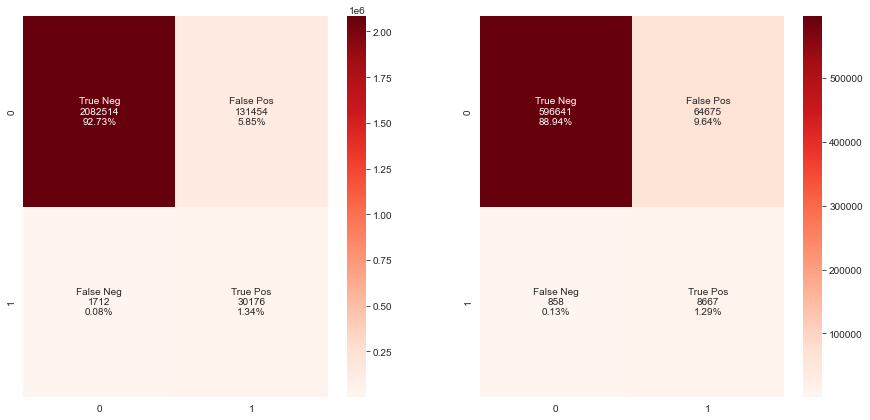

In [320]:
rfc.conf_mat(y_train_e, y_test)

#####  Compare scores

In [327]:
scores_df = scores_df.append(rf_scores)
scores_df.reset_index(drop=True,inplace=True)
scores_df

,Model Name,Accuracy,Precision,Recall,F1-Score,Type
0,NaN,0.940706,0.186698,0.946312,0.311868,trn
1,NaN,0.902312,0.118172,0.909921,0.209179,tst


### 3.2.1 eXtreme Gradient Boosted Decision Tree (XGBT) Classification

####  3.2.1.1 Optimization Parameters

In [332]:
# we use counter to decide how much weight to give the positive class (ransom address labels)
# because only 1.5% of our data-set contains positive datapoints
counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

kf = KFold(n_splits=5,shuffle = True, random_state = RAND_STATE)

# basic classifier constructor [for parameter search] 
xgb_clf = XGBClassifier(
    objective = 'binary:logistic', 
    use_label_encoder=False,
    #scale_pos_weight = estimate,
    random_state = RAND_STATE,)


xgb_params_in = {
    'n_estimators': stats.randint(150, 1000),
    'learning_rate': stats.uniform(0.01, 0.59),
    'subsample': stats.uniform(0.3, 0.6),
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': stats.uniform(0.5, 0.4),
    'scale_pos_weight' : stats.uniform(estimate,estimate**2),
    'min_child_weight': [1, 2, 3, 4]}

#### 3.2.1.2 xGBDT with tuning

In [333]:
# Convert encoded variables to integers for speed up
for col in colnames[-7:]: # TODO: make more robust
    X_train_e_df[col]=X_train_e_df[col].astype(np.int32)
X_train_e = X_train_e_df.to_numpy()
y_train_np = np.ravel(y_train['labels'].to_numpy()).astype(np.int32)
y_train_np[4546] == y_train.loc[[4546]]

,labels
4546,True


In [350]:
# fit the encoded, unbalanced data using scale_pos_weight to account for the imbalance to white labels
xgb = Model(X_train_e, y_train_np,
        X_train_e, X_test_e,
        xgb_clf, xgb_params_in, XGBClassifier, crss_vldtr=kf)

reading file  xgb_bestparams_sm_e_05.csv
{'colsample_bytree': 0.6808532306691525, 'learning_rate': 0.0995899737979832, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 436, 'scale_pos_weight': 69.09083926929269, 'subsample': 0.5375178528155568}
[16:37:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [337]:
xgb.params

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6808532306691525,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.0995899737979832,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 436,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 69.09083926929269,
 'subsample': 0.5375178528155568,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [348]:
xgb_best_params = xgb.best_params

In [340]:
xgb_opt_down_feat_ranks_df = pd.DataFrame(np.ravel(xgb.tuned.feature_importances_), index=colnames)
xgb_opt_down_feat_ranks_df.columns = ['feature importance']
xgb_opt_down_feat_ranks_df.sort_values(by='feature importance', ascending=False)

,feature importance
logbc_n_address,0.228022
year,0.188056
sunday,0.095687
income,0.057912
bc_neighbors,0.050378
bc_income,0.047697
saturday,0.046558
sig_looped,0.042397
neighbors,0.040608
looped,0.039723


In [346]:
xgb.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.931363,0.165583,0.949197,0.281976
0,tst,0.932738,0.165121,0.921365,0.280052


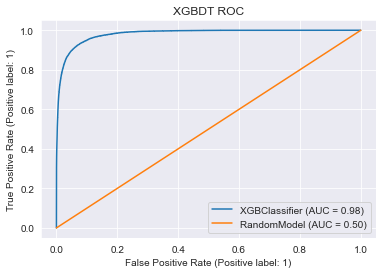

In [344]:
xgb.roc(y_test, 'XGBDT ROC')

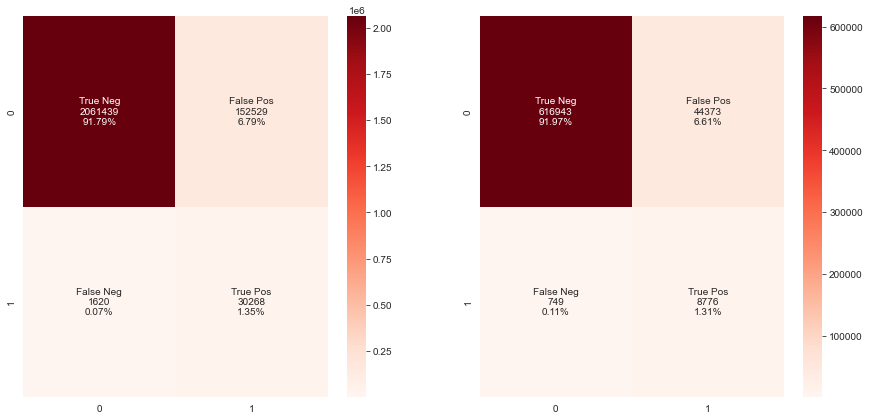

In [347]:
xgb.conf_mat(y_train,y_test)

In [98]:
# save results
pd.DataFrame([xgb_best_params]).to_csv('xgb_bestparams_train_e_05x.csv')

#### 3.2.1.3 Original data

In [352]:
# Original data

counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

kf = KFold(n_splits=5,shuffle = True, random_state = RAND_STATE)

# basic classifier constructor [for parameter search]
xgb_clf0 = XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 500,
    max_depth = 2,
    use_label_encoder=False,
    #scale_pos_weight = estimate,
    random_state = RAND_STATE,)

xgb_params_in0 = {'learning_rate': stats.uniform(0.01, 0.59), 'scale_pos_weight' : stats.uniform(estimate,estimate**2)}

READ_STATE = False
xgb0 = Model(X_train, y_train_np,
        X_train, X_test,
        xgb_clf0, xgb_params_in0, XGBClassifier)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA

[17:17:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.23097867011994386, 'scale_pos_weight': 74.34005885168789}
[17:18:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [355]:
xgb0.best_params

{'learning_rate': 0.23097867011994386, 'scale_pos_weight': 74.34005885168789}

In [356]:
xgb0.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.867966,0.091249,0.926336,0.166132
0,tst,0.866295,0.087764,0.895958,0.159868


In [358]:
xgb.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.931363,0.165583,0.949197,0.281976
0,tst,0.932738,0.165121,0.921365,0.280052


### 3.3 SVC

In [380]:
lsvc_cl = LinearSVC(random_state = RAND_STATE)
lsvc_params_in = {
    "loss": ['hinge','squared_hinge'],
    "fit_intercept": [True, False],
    "max_iter": [250,500],
    "class_weight" : ['balanced', None],}
lsvc = Model(
    e_ds.X_train_sm, e_ds.y_train_sm,
    X_train_e, X_test_e,
    lsvc_cl, lsvc_params_in, LinearSVC)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/sklearn/svm/_b

{'max_iter': 500, 'loss': 'hinge', 'fit_intercept': False, 'class_weight': 'balanced'}


In [381]:
lsvc.score(y_train,y_test)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.725865,0.039154,0.777691,0.074554
0,tst,0.708867,0.038320,0.809449,0.073176


In [382]:
lsvc.params

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': True,
 'fit_intercept': False,
 'intercept_scaling': 1,
 'loss': 'hinge',
 'max_iter': 500,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}